In [1]:
!pip install pandas numpy matplotlib tensorflow tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\wlstj\AppData\Local\Temp\pip-install-iykenef7\tensorflow-gpu_ec4ffec559a64e63912331596eed18f6\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [6]:
directory = os.getcwd()
file_path = os.path.join('src', 'datasets')
csv_path = os.path.join(file_path, "jena_climate_2009_2016.csv")
df = pd.read_csv(csv_path)

In [7]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
## Parameter Setting For Training
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000

## Parameter in Training 
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [9]:
# Seed Setting for Reproducibility
tf.random.set_seed(13)

In [10]:
## if your PC is equipped with GPU device,tensorflow gpu activation
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus= tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [14]:
## time-series prediction of univariate value
uni_data = df['T (degC)'] # y value = temperature 
uni_data.index = df['Date Time'] # x value = time-series
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [15]:
## data arrangement
uni_data = uni_data.values

In [16]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [17]:
## data standardization
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [18]:
uni_data = (uni_data-uni_train_mean) / uni_train_std
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

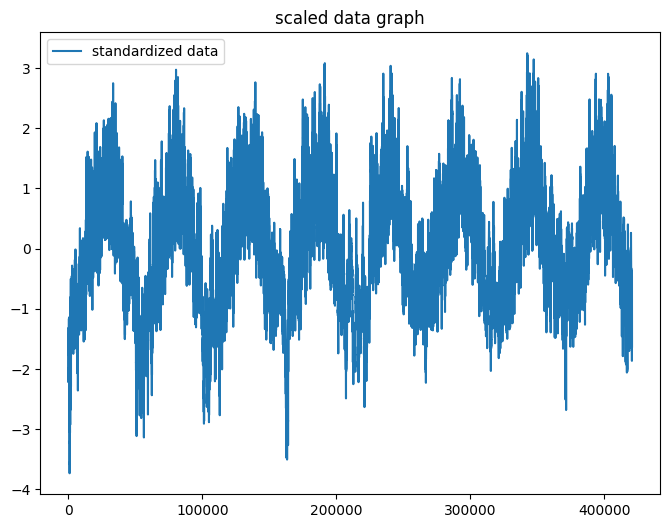

In [19]:
plt.plot(np.arange(len(uni_data)), uni_data, label='standardized data')
plt.title('scaled data graph')
plt.legend()
plt.show()

In [22]:
# Dataset Setting 
def univariate_data(dataset, start_index, end_index, data_window, target):
    data, labels = [], []
    start_index = start_index + data_window

    if end_index is None:
        end_index = len(dataset) - target

    for i in range(start_index, end_index):
        indices = range(i-data_window, i)
        data.append(np.reshape(dataset[indices], (data_window,1)))
        labels.append(dataset[i+target])

    return np.array(data), np.array(labels)

In [23]:
data_window = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           data_window,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       data_window, 
                                       univariate_future_target)

In [24]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(299980, 20, 1)
(299980,)


In [25]:
def baseline(history):
    return np.mean(history)

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [42]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i :
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5) *2])
    plt.xlabel('Time-Step')
    return plt

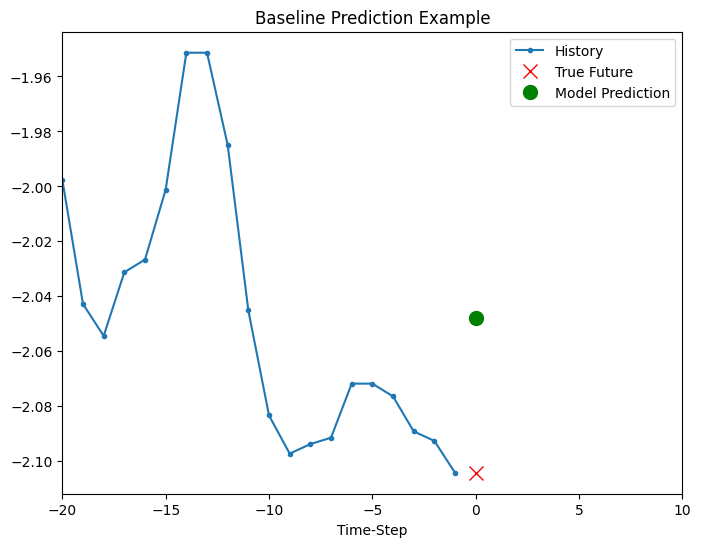

In [32]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [44]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [50]:
## model build
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

## model compile
simple_lstm_model.compile(optimizer='adam', loss='mae', metrics='mse')

## model fitting
history = simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data = val_univariate, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 3s 6ms/step - loss: 0.1688 - mse: 0.0955 - val_loss: 0.0505 - val_mse: 0.0046
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0547 - mse: 0.0084 - val_loss: 0.0298 - val_mse: 0.0020
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0355 - mse: 0.0030 - val_loss: 0.0223 - val_mse: 0.0011
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0024 - val_loss: 0.0196 - val_mse: 8.7793e-04
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0228 - mse: 0.0013 - val_loss: 0.0190 - val_mse: 8.1207e-04
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0248 - mse: 0.0015 - val_loss: 0.0187 - val_mse: 7.7822e-04
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0231 - mse: 0.0013 - val_loss: 0.0175 - val_mse: 7.0808e-04
Epoch 8/10
200/200 [==============================] - 1s 5ms

In [35]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

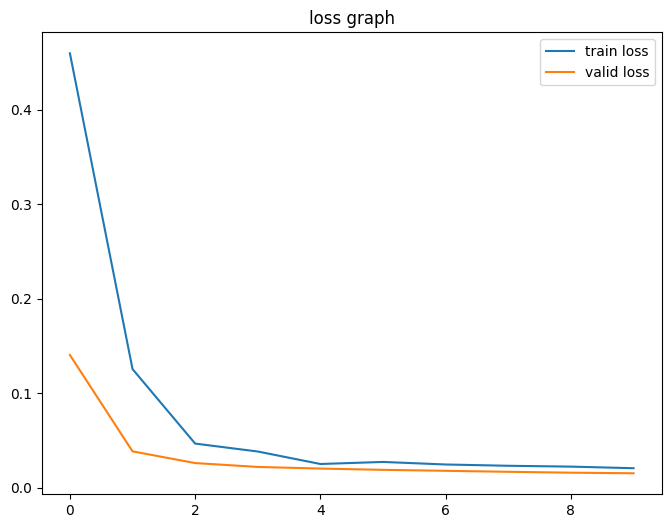

In [46]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='train loss')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='valid loss')
plt.legend()
plt.title('loss graph')
plt.show()

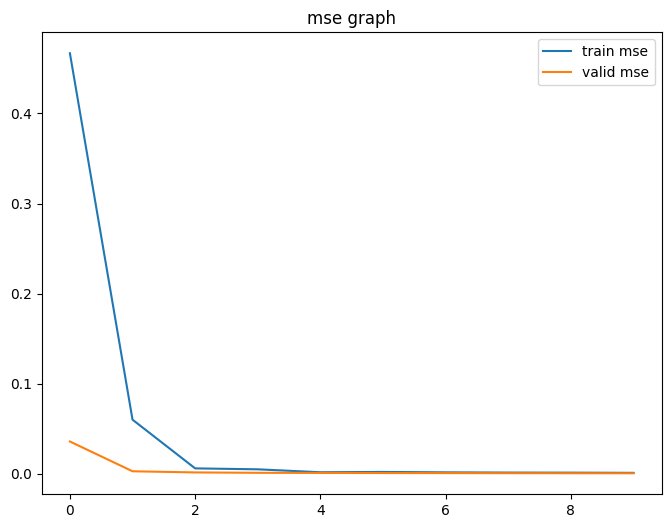

In [47]:
plt.plot(np.arange(len(history.history['mse'])),history.history['mse'], label='train mse')
plt.plot(np.arange(len(history.history['val_mse'])),history.history['val_mse'], label='valid mse')
plt.legend()
plt.title('mse graph')
plt.show()

8/8 [==============================] - 0s 4ms/step


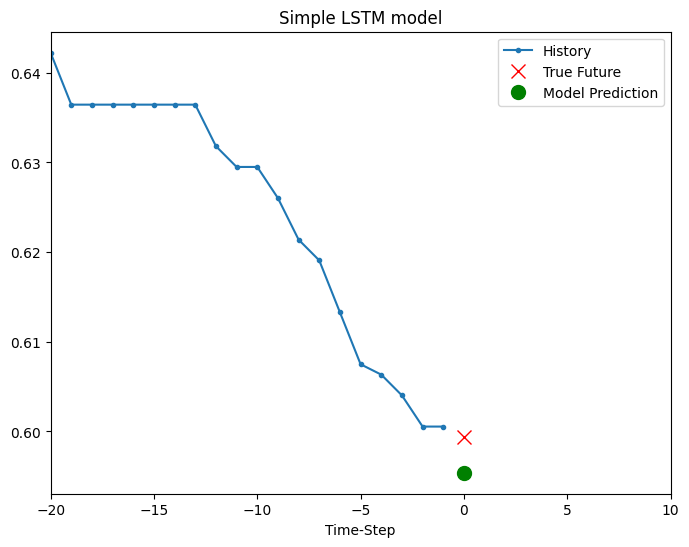

8/8 [==============================] - 0s 1ms/step


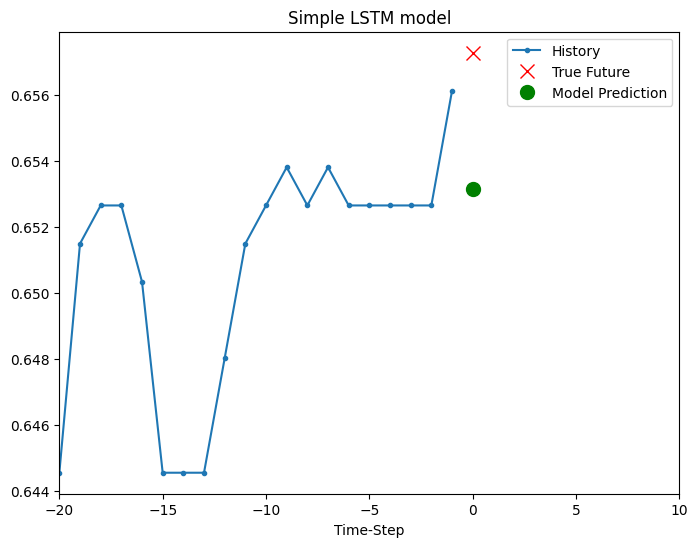

8/8 [==============================] - 0s 983us/step


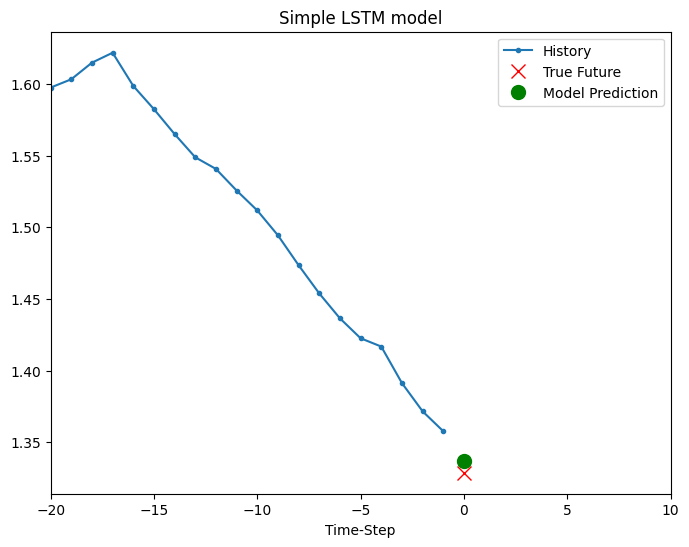

In [51]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()